In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import keras.backend as K
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
#from sklearn.svm import OneClassSVM
import joblib
from joblib import dump
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import MeanSquaredError
from keras.regularizers import l2, l1
from keras.models import model_from_json

Se carga el dataset

In [2]:
print("Se está cargando el dataset, aguarde un momento...")
filePath = "C:/Users/raul.blanco/Documents/4 - Personales/UBA/Repositorios/IA/Trabajo-Final/solar_wind.csv"
dataset = pd.read_csv(filepath_or_buffer=filePath, header=0, sep=",")
dataset = dataset.dropna()
print("Dataset cargado correctamente.")

Se está cargando el dataset, aguarde un momento...
Dataset cargado correctamente.


Se realiza One Hot Encodding

In [3]:
#dataset_org = dataset
dataset = pd.get_dummies(dataset, columns=['source', 'period'], prefix=['source', 'period'])

Matriz de correlación

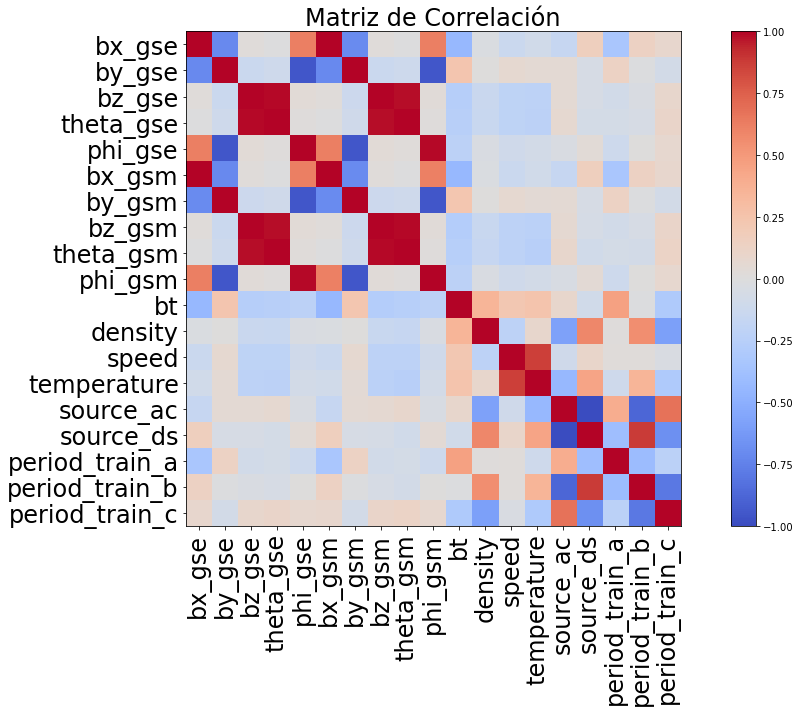

In [4]:
data = dataset.drop({'timedelta'},axis=1)
correlation_matrix = data.corr()
correlation_array = correlation_matrix.to_numpy()
correlation_matrix = np.corrcoef(correlation_array, rowvar=False)
plt.figure(figsize=(15, 10))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.xticks(range(len(data.columns)), data.columns, rotation=90, fontsize=24)
plt.yticks(range(len(data.columns)), data.columns, fontsize=24)

plt.colorbar()
plt.title('Matriz de Correlación', fontsize=24)
plt.tight_layout()
plt.show()

In [ ]:
data = dataset.drop({'timedelta'}, axis=1)
correlation_matrix = data.corr()
correlation_array = correlation_matrix.to_numpy()
correlation_matrix = np.corrcoef(correlation_array, rowvar=False)
plt.figure(figsize=(15, 10))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
for i in range(len(data.columns)):
    for j in range(len(data.columns)):
        plt.text(j, i, f'{correlation_matrix[i, j]:.2f}', ha='center', va='center', color='black')
plt.xticks(range(len(data.columns)), data.columns, rotation=90, fontsize=24)
plt.yticks(range(len(data.columns)), data.columns, fontsize=24)
plt.colorbar()
plt.title('Matriz de Correlación', fontsize=24)
plt.tight_layout()
plt.show()

Se divide el dataset en train y test

In [5]:
train_size = int(len(dataset) * 0.8)
train_data = dataset[:train_size]
test_data = dataset[train_size:]

In [6]:
train_data.set_index(['timedelta'])

,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bx_gsm,by_gsm,bz_gsm,theta_gsm,phi_gsm,bt,density,speed,temperature,source_ac,source_ds,period_train_a,period_train_b,period_train_c
timedelta,,,,,,,,,,,,,,,,,,,
0 days 00:00:00,-5.55,3.00,1.25,11.09,153.37,-5.55,3.00,1.25,11.09,153.37,6.80,1.53,383.92,110237.0,1,0,1,0,0
0 days 00:01:00,-5.58,3.16,1.17,10.10,151.91,-5.58,3.16,1.17,10.10,151.91,6.83,1.69,381.79,123825.0,1,0,1,0,0
0 days 00:02:00,-5.15,3.66,0.85,7.87,146.04,-5.15,3.66,0.85,7.87,146.04,6.77,1.97,389.11,82548.0,1,0,1,0,0
0 days 00:03:00,-5.20,3.68,0.68,6.17,146.17,-5.20,3.68,0.68,6.17,146.17,6.74,1.97,389.11,82548.0,1,0,1,0,0
0 days 00:04:00,-5.12,3.68,0.49,4.62,145.72,-5.12,3.68,0.49,4.62,145.72,6.65,1.77,384.26,94269.0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233 days 22:15:00,1.85,-1.95,0.55,11.46,313.59,1.85,-1.78,0.97,20.74,316.17,2.74,4.46,355.14,28303.0,1,0,0,0,1
1233 days 22:16:00,0.78,-2.77,0.56,10.93,285.72,0.77,-2.58,1.17,23.46,286.73,2.93,4.38,356.59,46966.0,1,0,0,0,1
1233 days 22:17:00,0.53,-2.79,0.64,12.76,280.70,0.52,-2.58,1.26,25.56,281.46,2.91,5.03,356.57,29625.0,1,0,0,0,1


Gráfico de la variable bt vs el tiempo

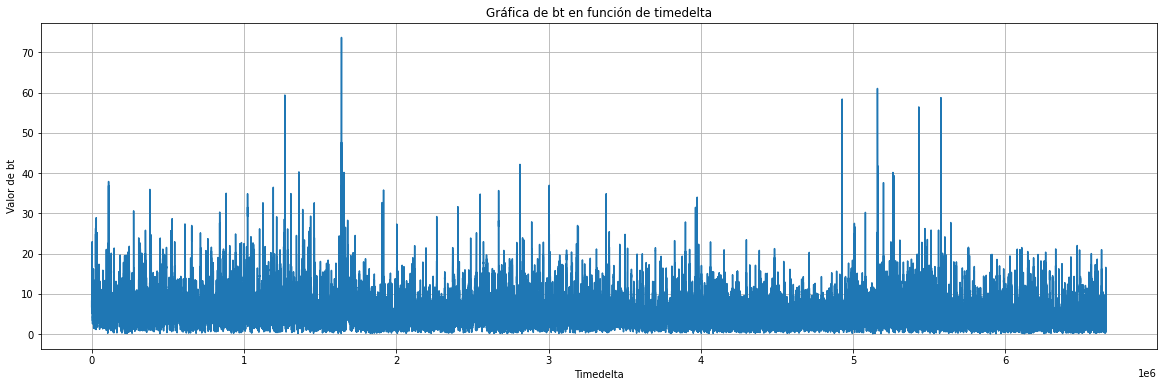

In [7]:
plt.figure(figsize=(20, 6))
plt.plot(train_data.index, train_data['bt'], linestyle='-')
plt.xlabel('Timedelta')
plt.ylabel('Valor de bt')
plt.title('Gráfica de bt en función de timedelta')
plt.grid(True)
plt.show()

Gráfico de la distribución de bt

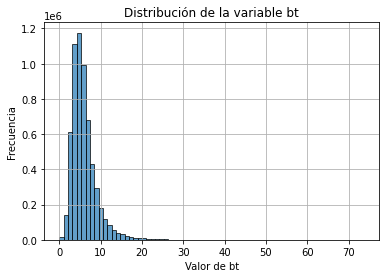

In [8]:
plt.hist(train_data['bt'], bins=70, edgecolor='black', alpha=0.7)
plt.xlabel('Valor de bt')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable bt')
plt.grid(True)
plt.show()

Agrego media y desvío standard

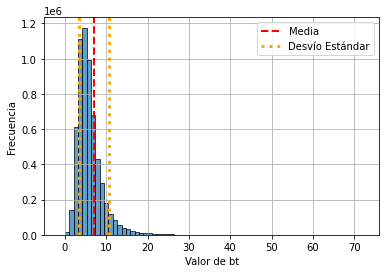

In [9]:
bt_values = train_data['bt']
mean_value = 7.069
std_deviation = 3.693
plt.hist(bt_values, bins=70, edgecolor='black', alpha=0.7)
plt.axvline(x=mean_value, color='red', linestyle='dashed', linewidth=2, label='Media')
plt.axvline(x=mean_value - std_deviation, color='orange', linestyle='dotted', linewidth=3, label='Desvío Estándar')
plt.axvline(x=mean_value + std_deviation, color='orange', linestyle='dotted', linewidth=3)
plt.xlabel('Valor de bt')
plt.ylabel('Frecuencia')
plt.xlim(left=-5, right=76)
plt.legend()
plt.grid(True)
plt.show()

Se preparan los dataset para ser guardados localmente

In [10]:
test_data_pd = pd.DataFrame(test_data)
test_data_pd.reset_index()
test_timedelta = test_data[['timedelta']]
test_timedelta.reset_index(drop=True, inplace = True)
test_data_out = pd.concat([test_timedelta, test_data_pd], axis = 'columns')
test_data = test_data.drop(['timedelta'], axis=1)
train_data = train_data.drop(['timedelta'], axis=1)

Se introduce las anomalías en los dataset de entrenamiento y de testeo

In [11]:
feature = 'bt'
anomaly_percentage_train = 0.2
sample_indices_train = train_data.sample(frac=anomaly_percentage_train, random_state=42).index 
num_anomalies_train = int(len(train_data) * anomaly_percentage_train)+1
train_data.loc[sample_indices_train, feature] = np.random.normal(loc=40, scale=1.5, size=len(sample_indices_train))
#train_data.loc[sample_indices_train, feature] = np.random.uniform(low=0, high=100, size=num_anomalies_train)

In [12]:
anomaly_percentage_test = 0.01
sample_indices_test = test_data.sample(frac=anomaly_percentage_test, random_state=42).index
num_anomalies_test = int(len(test_data) * anomaly_percentage_test)+1
test_data.loc[sample_indices_test, feature] = np.random.normal(loc=40, scale=1.5, size=len(sample_indices_test))
#test_data.loc[sample_indices_test, feature] = np.random.uniform(low=0, high=100, size=len(sample_indices_test))

Etiqueto los registros que tienen anomalías

In [13]:
train_data['class'] = 0
train_data.loc[sample_indices_train, 'class'] = 1
test_data['class'] = 0
test_data.loc[sample_indices_test, 'class'] = 1

In [14]:
count = (test_data['class'] == 1).sum()
count1 = (test_data['class'] == 0).sum()
print(f'En el dataset TEST el número de anomalias es {count} y {count1} son valores normales')

En el dataset TEST el número de anomalias es 15142 y 1499075 son valores normales


In [15]:
test_timedelta.index = test_data_pd.index
test_data_out = pd.concat([test_timedelta, test_data_pd], axis = 'columns')

Grafico train con anomalías

In [19]:
bt_values.describe()

count    6.056864e+06
mean     1.274530e+01
std      1.394215e+01
min      7.000000e-02
25%      4.240000e+00
50%      6.030000e+00
75%      1.089000e+01
max      7.258000e+01
Name: bt, dtype: float64

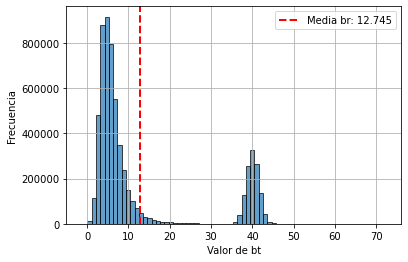

In [20]:
bt_values = train_data['bt']
plt.hist(bt_values, bins=70, edgecolor='black', alpha=0.7)
media1 = 12.745
plt.axvline(x=media1, color='r', linestyle='dashed', linewidth=2, label=f'Media br: {media1}')
plt.xlabel('Valor de bt')
plt.ylabel('Frecuencia')
plt.xlim(left=-5, right=76)
plt.grid(True)
plt.legend()
plt.show()

Grafico test con anomalías

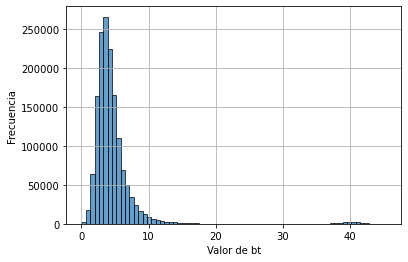

In [22]:
plt.hist(test_data['bt'], bins=70, edgecolor='black', alpha=0.7)
plt.xlabel('Valor de bt')
plt.ylabel('Frecuencia')
#plt.title('Distribución de la variable bt') 
plt.grid(True)
plt.show()

In [26]:
test_data['bt'].describe()

count    1.514217e+06
mean     4.653375e+00
std      4.093832e+00
min      3.000000e-02
25%      2.990000e+00
50%      3.910000e+00
75%      5.150000e+00
max      4.540829e+01
Name: bt, dtype: float64

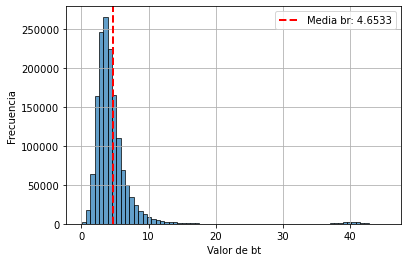

In [27]:
bt_values = test_data['bt']
plt.hist(bt_values, bins=70, edgecolor='black', alpha=0.7)
media1 = 4.6533
plt.axvline(x=media1, color='r', linestyle='dashed', linewidth=2, label=f'Media br: {media1}')
plt.xlabel('Valor de bt')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.legend()
plt.show()

A partir de ahora, comienzo a prepara el dataset para el entrenamiento

In [28]:
X_train = train_data.drop('class', axis=1).values
y_train = train_data['class'].values
X_test = test_data.drop('class', axis=1).values
y_test = test_data['class'].values

In [29]:
X_train = pd.DataFrame(X_train, columns=['bx_gse', 'by_gse', 'bz_gse', 'theta_gse',
       'phi_gse', 'bx_gsm', 'by_gsm', 'bz_gsm', 'theta_gsm', 'phi_gsm', 'bt',
       'density', 'speed', 'temperature', 'source_ac', 'source_ds', 'period_train_a',
       'period_train_b', 'period_train_c'])
y_train = pd.DataFrame(y_train, columns = ['Class'])

Aplico PCA a train

In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

componentes = 9
pca = PCA(n_components = componentes)
X_train_pca = pca.fit_transform(X_train)
#X_test_pca = pca.transform(X_test)

X_train_pca = pca.fit_transform(X_train_scaled)
#X_test_pca = pca.transform(X_test_scaled)
data_train_X = X_train_pca
#data_test_X = X_test_pca  

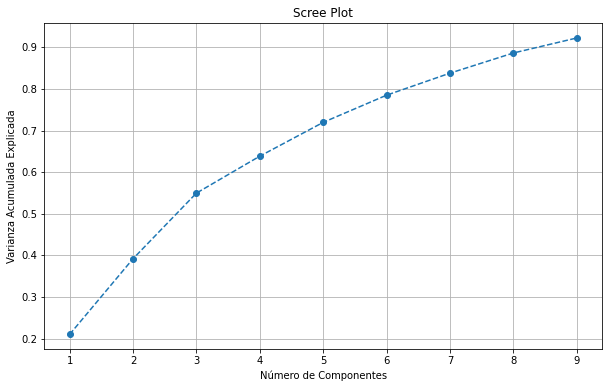

In [31]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(10, 6))
plt.plot(range(1, componentes + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada Explicada')
plt.title('Scree Plot')
plt.xticks(range(1, componentes + 1))
plt.grid(True)
plt.show()

### RBM

In [32]:
def weighted_mean_squared_error(y_true, y_pred):
    weights = K.cast(K.not_equal(y_true, 0), K.floatx())
    return K.mean(K.square((y_pred - y_true) * weights), axis=-1)  

visible = Input(shape=(data_train_X.shape[1],))
#hidden = Dense(64, activation='sigmoid')(visible)
hidden = Dense(16, activation='sigmoid', kernel_regularizer=l1(0.001))(visible)
hidden = Dropout(0.5)(hidden)
hidden = Dense(12, activation='sigmoid', kernel_regularizer=l1(0.001))(visible)
#hidden = Dense(32, activation='sigmoid')(visible)
hidden = Dropout(0.5)(hidden)
visible_recon = Dense(data_train_X.shape[1], activation='sigmoid')(hidden)

rbm_model = Model(inputs=visible, outputs=visible_recon)
rbm_model.compile(optimizer=Adam(learning_rate=0.0001), loss=weighted_mean_squared_error)

In [33]:
start_time = time.time()
hist_rbm = rbm_model.fit(data_train_X, data_train_X, epochs=50, batch_size=320, validation_split=0.1)
end_time = time.time()
total_time = end_time - start_time
print(f"Tiempo total de entrenamiento: {total_time:.2f} segundos")

Epoch 1/50
17035/17035 [==============================] - 20s 1ms/step - loss: 1.8611 - val_loss: 1.4654
Epoch 2/50
17035/17035 [==============================] - 19s 1ms/step - loss: 1.6986 - val_loss: 1.3590
Epoch 3/50
17035/17035 [==============================] - 18s 1ms/step - loss: 1.6503 - val_loss: 1.3097
Epoch 4/50
17035/17035 [==============================] - 19s 1ms/step - loss: 1.6220 - val_loss: 1.2943
Epoch 5/50
17035/17035 [==============================] - 23s 1ms/step - loss: 1.6081 - val_loss: 1.2830
Epoch 6/50
17035/17035 [==============================] - 30s 2ms/step - loss: 1.5961 - val_loss: 1.2813
Epoch 7/50
17035/17035 [==============================] - 30s 2ms/step - loss: 1.5820 - val_loss: 1.2873
Epoch 8/50
17035/17035 [==============================] - 28s 2ms/step - loss: 1.5722 - val_loss: 1.3046
Epoch 9/50
17035/17035 [==============================] - 27s 2ms/step - loss: 1.5662 - val_loss: 1.3134
Epoch 10/50
17035/17035 [==============================

In [34]:
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)
componentes = 9
pca = PCA(n_components = componentes)
X_test_pca = pca.fit_transform(X_test)
X_test_pca = pca.fit_transform(X_test_scaled)
data_test_X = X_test_pca

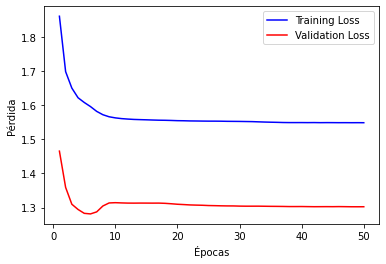

47320/47320 [==============================] - 27s 574us/step


In [35]:
loss = hist_rbm.history['loss']
val_loss = hist_rbm.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()
#X_train_pred = rbm_model.predict(data_train_X)
X_test_pred_RBM = rbm_model.predict(data_test_X)

Train

In [36]:
X_train_pred_RBM = rbm_model.predict(data_train_X)

189277/189277 [==============================] - 136s 719us/step


Threshold =  3.5


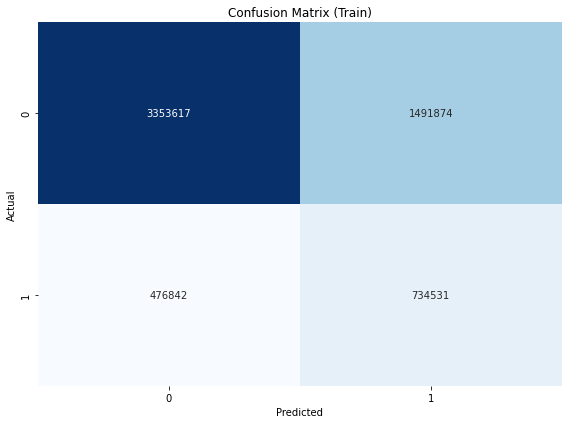

Classification Report (Train):
               precision    recall  f1-score   support

           0       0.88      0.69      0.77   4845491
           1       0.33      0.61      0.43   1211373

    accuracy                           0.67   6056864
   macro avg       0.60      0.65      0.60   6056864
weighted avg       0.77      0.67      0.70   6056864



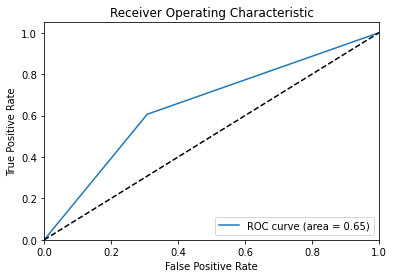

AUC: 0.6492366195332562
Threshold =  3.5


In [37]:
threshold = float(input("Ingrese el Threshold a utilizar: "))
print("Threshold = ", threshold)

# Calcular la matriz de confusión
y_train_pred_RBM = np.where(np.linalg.norm(data_train_X - X_train_pred_RBM, axis=1) > threshold, 1, 0)

cm_test = confusion_matrix(y_train, y_train_pred_RBM)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix (Train)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Calcular el classification report
classification_test = classification_report(y_train, y_train_pred_RBM)
print('Classification Report (Train):\n', classification_test)

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred_RBM)
roc_auc = auc(fpr, tpr)
# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Imprimir el AUC
print('AUC:', roc_auc)
print("Threshold = ", threshold)

Test

Threshold =  4.2


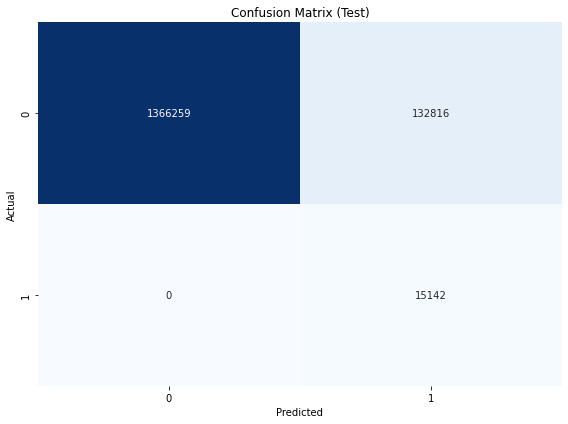

Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      0.91      0.95   1499075
           1       0.10      1.00      0.19     15142

    accuracy                           0.91   1514217
   macro avg       0.55      0.96      0.57   1514217
weighted avg       0.99      0.91      0.95   1514217



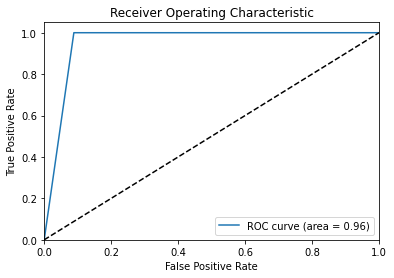

AUC: 0.9557006820872871
Threshold =  4.2


In [43]:
threshold = float(input("Ingrese el Threshold a utilizar: "))
print("Threshold = ", threshold)

# Calcular la matriz de confusión
y_test_pred_RBM = np.where(np.linalg.norm(data_test_X - X_test_pred_RBM, axis=1) > threshold, 1, 0)

cm_test = confusion_matrix(y_test, y_test_pred_RBM)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Calcular el classification report
classification_test = classification_report(y_test, y_test_pred_RBM)
print('Classification Report (Test):\n', classification_test)

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_RBM)
roc_auc = auc(fpr, tpr)
# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Imprimir el AUC
print('AUC:', roc_auc)
print("Threshold = ", threshold)

In [44]:
name = input("Ingrese el nombre de los archivos a generar sin extención: ")
# serializa el modelo para JSON
model_json = rbm_model.to_json()
with open(f"{name}.json", "w") as json_file:
    json_file.write(model_json)
#serializan los pesos (weights) para HDF5
rbm_model.save_weights(f"{name}.h5")
print("Modelo guardado en el PC")

Modelo guardado en el PC


### LSTM Autoencoder

In [45]:
X_train_3d = X_train_pca.reshape(X_train_pca.shape[0], 1, X_train_pca.shape[1])
#X_test_3d = X_test_pca.reshape(X_test_pca.shape[0], 1, X_test_pca.shape[1])

In [46]:
def weighted_mean_squared_error(y_true, y_pred):
    weights = K.cast(K.not_equal(y_true, 0), K.floatx())
    return K.mean(K.square((y_pred - y_true) * weights), axis=-1)   


input_dim = X_train_3d.shape[2]
timesteps = X_train_3d.shape[1]

inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(64, activation='relu', return_sequences=True)(inputs)
encoded = LSTM(32, activation='relu', return_sequences=True)(encoded)
encoded = LSTM(8, activation='relu', return_sequences=False)(encoded) 
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(8, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(input_dim, activation='linear', return_sequences=True)(decoded)
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss=weighted_mean_squared_error)

In [47]:
start_time = time.time()
hist = autoencoder.fit(X_train_3d, X_train_3d, epochs=25, batch_size=320, validation_split=0.1)
end_time = time.time()
total_time = end_time - start_time
print(f"Tiempo total de entrenamiento: {total_time:.2f} segundos")

Epoch 1/25
17035/17035 [==============================] - 432s 25ms/step - loss: 0.2116 - val_loss: 0.0502
Epoch 2/25
17035/17035 [==============================] - 387s 23ms/step - loss: 0.0590 - val_loss: 0.0301
Epoch 3/25
17035/17035 [==============================] - 388s 23ms/step - loss: 0.0294 - val_loss: 0.0255
Epoch 4/25
17035/17035 [==============================] - 391s 23ms/step - loss: 0.0193 - val_loss: 0.0221
Epoch 5/25
17035/17035 [==============================] - 395s 23ms/step - loss: 0.0146 - val_loss: 0.0181
Epoch 6/25
17035/17035 [==============================] - 418s 25ms/step - loss: 0.0108 - val_loss: 0.0032
Epoch 7/25
17035/17035 [==============================] - 395s 23ms/step - loss: 0.0101 - val_loss: 0.0032
Epoch 8/25
17035/17035 [==============================] - 394s 23ms/step - loss: 0.0099 - val_loss: 0.0032
Epoch 9/25
17035/17035 [==============================] - 393s 23ms/step - loss: 0.0092 - val_loss: 0.0029
Epoch 10/25
17035/17035 [============

In [48]:
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)
componentes = 9
pca = PCA(n_components = componentes)
X_test_pca = pca.fit_transform(X_test)
X_test_pca = pca.fit_transform(X_test_scaled)
data_test_X = X_test_pca
X_test_3d = X_test_pca.reshape(X_test_pca.shape[0], 1, X_test_pca.shape[1])

Train

In [49]:
X_train_pred_LSTM = autoencoder.predict(X_train_3d)

189277/189277 [==============================] - 370s 2ms/step


Threshold =  0.08


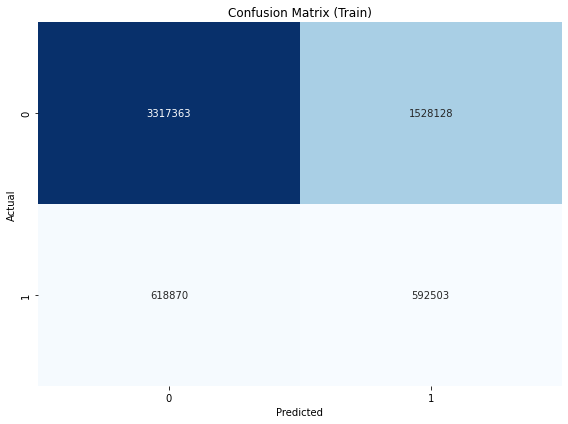

Classification Report (Train):
               precision    recall  f1-score   support

           0       0.84      0.68      0.76   4845491
           1       0.28      0.49      0.36   1211373

    accuracy                           0.65   6056864
   macro avg       0.56      0.59      0.56   6056864
weighted avg       0.73      0.65      0.68   6056864



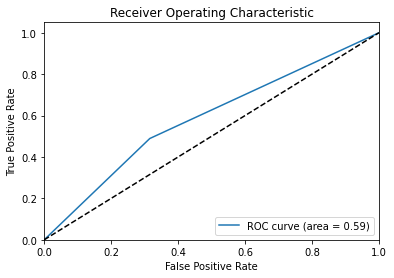

AUC: 0.5868728794340043
Threshold =  0.08


In [53]:
threshold = float(input("Ingrese el Threshold a utilizar: "))
print("Threshold = ", threshold)
y_train_pred_lstm = np.where(np.linalg.norm(X_train_3d - X_train_pred_LSTM, axis=(1, 2)) > threshold, 1, 0)
cm_test = confusion_matrix(y_train, y_train_pred_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix (Train)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()
classification_test = classification_report(y_train, y_train_pred_lstm)
print('Classification Report (Train):\n', classification_test)
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred_lstm)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
print('AUC:', roc_auc)
print("Threshold = ", threshold)

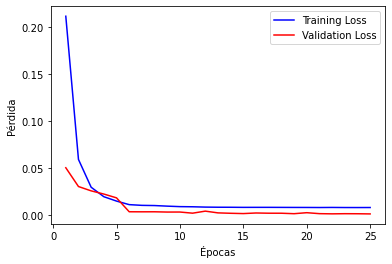

In [54]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


Test

In [55]:
X_test_pred = autoencoder.predict(X_test_3d)

47320/47320 [==============================] - 73s 2ms/step


Threshold =  17.0


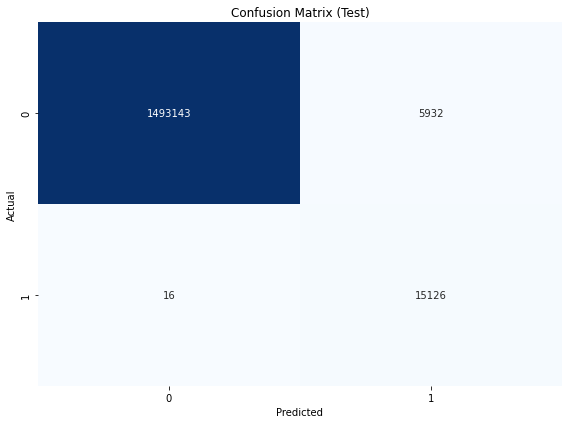

Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1499075
           1       0.72      1.00      0.84     15142

    accuracy                           1.00   1514217
   macro avg       0.86      1.00      0.92   1514217
weighted avg       1.00      1.00      1.00   1514217



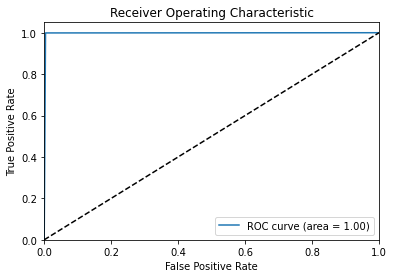

AUC: 0.9974931147663455
Threshold =  17.0


In [68]:
threshold = float(input("Ingrese el Threshold a utilizar: "))
print("Threshold = ", threshold)
y_test_pred = np.where(np.linalg.norm(X_test_3d - X_test_pred, axis=(1, 2)) > threshold, 1, 0)
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()
classification_test = classification_report(y_test, y_test_pred)
print('Classification Report (Test):\n', classification_test)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
print('AUC:', roc_auc)
print("Threshold = ", threshold)

Se guarda los dataset de train y test y seguidamente el modelo entrenado

In [69]:
# guardo el dataset train
X_train.to_csv('X_train.csv')
y_train_pd = pd.DataFrame(y_train, columns = ['class'])
y_train_pd.to_csv('y_train.csv')
print("Se guardó dataset de train con el nombre X_train.csv e y_train.csv")
# guardo el dataset test
test_data_out.to_csv('test_data.csv')
y_test_pd = pd.DataFrame(y_test, columns = ['class'])
y_test_pd.to_csv('y_test.csv')
print("Se guardó dataset de test con el nombre test_data.csv")

Se guardó dataset de train con el nombre X_train.csv e y_train.csv
Se guardó dataset de test con el nombre test_data.csv


In [70]:
name = input("Ingrese el nombre de los archivos a generar sin extención: ")
# serializa el modelo para JSON
model_json = autoencoder.to_json()
with open(f"{name}.json", "w") as json_file:
    json_file.write(model_json)
#serializan los pesos (weights) para HDF5
autoencoder.save_weights(f"{name}.h5")
print("Modelo guardado en el PC")

Modelo guardado en el PC


### Isolation Forest

In [71]:
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)
componentes = 9
pca = PCA(n_components = componentes)
X_test_pca = pca.fit_transform(X_test)
X_test_pca = pca.fit_transform(X_test_scaled)
data_test_X = X_test_pca

Tiempo total de entrenamiento: 277.81 segundos
i = 3


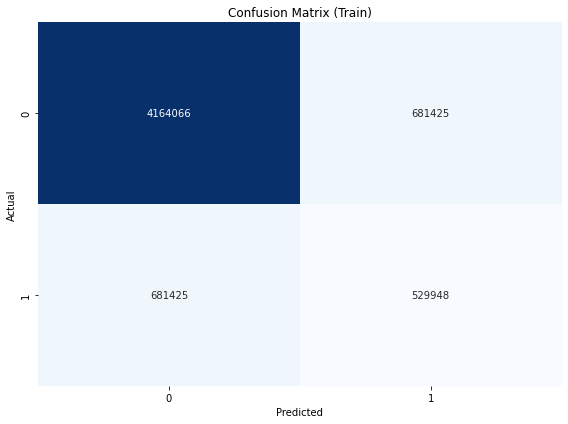

Classification Report (Train):
               precision    recall  f1-score   support

           0       0.86      0.86      0.86   4845491
           1       0.44      0.44      0.44   1211373

    accuracy                           0.77   6056864
   macro avg       0.65      0.65      0.65   6056864
weighted avg       0.77      0.77      0.77   6056864



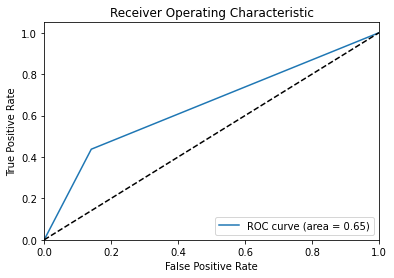

AUC: 0.6484232003034219


In [72]:
for i in range(3,4):
    #Modelo
    model_if = IsolationForest(n_estimators=112 , contamination=0.2, random_state=0)
    #Entreno el modelo
    start_time = time.time()
    model_if.fit(data_train_X,data_train_X)
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Tiempo total de entrenamiento: {total_time:.2f} segundos")
    
    #Guardo el modelo.
    #joblib.dump(model_if, 'model_if.joblib')
    # serializa el modelo para JSON
    #model_json = model_if.to_json()
    #with open("model_if.json", "w") as json_file:
    #    json_file.write(model_json)
    #serializan los pesos (weights) para HDF5
    #model_if.save_weights("model_if.h5")
    #print("Modelo guardado localmente")
    print("i =", i)
    X_train_pred_if = model_if.predict(data_train_X)
    X_train_pred_if = np.where(X_train_pred_if == 1, 0, np.where(X_train_pred_if == -1, 1, X_train_pred_if))
    threshold = 5

    # Calcular la matriz de confusión
    #y_test_pred_if = np.where(np.linalg.norm(data_test_X - X_test_pred_if, axis=1) > threshold, 1, 0)

    cm_test = confusion_matrix(y_train, X_train_pred_if)

    # Visualizar la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.title('Confusion Matrix (Train)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # Calcular el classification report
    classification_test = classification_report(y_train, X_train_pred_if)
    print('Classification Report (Train):\n', classification_test)

    # Calcular la curva ROC y el AUC
    fpr, tpr, thresholds = roc_curve(y_train, X_train_pred_if)
    roc_auc = auc(fpr, tpr)
    # Graficar la curva ROC
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Imprimir el AUC
    print('AUC:', roc_auc)


In [73]:
X_test_pred_if = model_if.predict(data_test_X)

In [74]:
X_test_pred_if = np.where(X_test_pred_if == 1, 0, np.where(X_test_pred_if == -1, 1, X_test_pred_if))

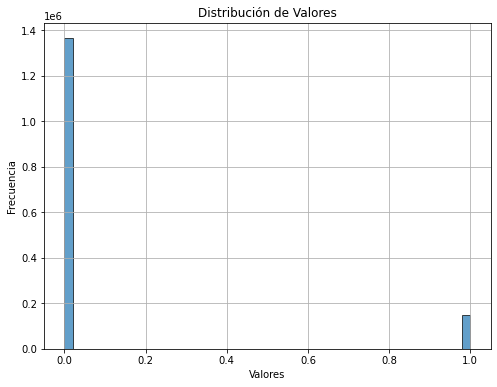

In [75]:
plt.figure(figsize=(8, 6))  # Tamaño de la figura

# Generar el histograma de la distribución de valores
plt.hist(X_test_pred_if, bins=50, edgecolor='black', alpha=0.7)

plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.title('Distribución de Valores')
plt.grid(True)
plt.show()

In [76]:
count_0 = np.bincount(y_test == 0)[0]
count_1 = np.bincount(y_test == 1)[0]

print(f"Cantidad de 0: {count_0}")
print(f"Cantidad de 1: {count_1}")

Cantidad de 0: 15142
Cantidad de 1: 1499075


Threshold =  1.0


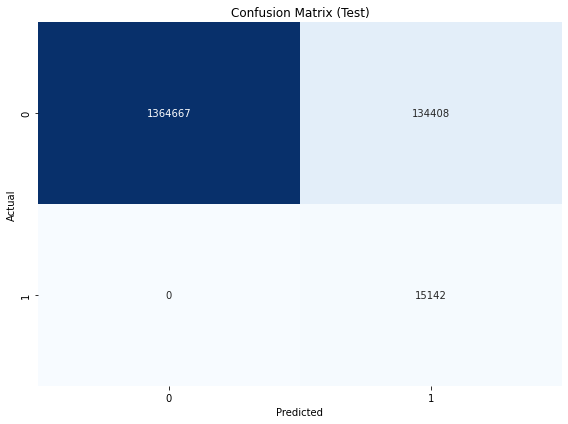

Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      0.91      0.95   1499075
           1       0.10      1.00      0.18     15142

    accuracy                           0.91   1514217
   macro avg       0.55      0.96      0.57   1514217
weighted avg       0.99      0.91      0.95   1514217



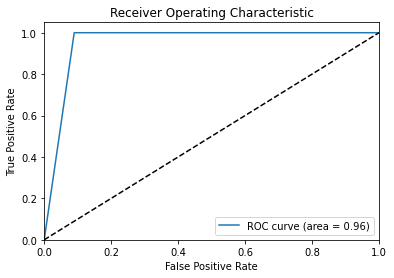

AUC: 0.9551696879742507
Threshold =  1.0


In [77]:
threshold = float(input("Ingrese el Threshold a utilizar: "))
print("Threshold = ", threshold)

# Calcular la matriz de confusión
#y_test_pred_if = np.where(np.linalg.norm(data_test_X - X_test_pred_if, axis=1) > threshold, 1, 0)

cm_test = confusion_matrix(y_test, X_test_pred_if)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Calcular el classification report
classification_test = classification_report(y_test, X_test_pred_if)
print('Classification Report (Test):\n', classification_test)

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, X_test_pred_if)
roc_auc = auc(fpr, tpr)
# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Imprimir el AUC
print('AUC:', roc_auc)
print("Threshold = ", threshold)

In [78]:
name = input("Ingrese el nombre de los archivos a generar sin extención: ")
joblib.dump(model_if, f'{name}.joblib')
print("Modelo guardado en el PC")

Modelo guardado en el PC
